In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import scipy.signal as sp
import datetime as dt
from beam2ENU import beam2ENU
import seawater as sw
import oceans as oc
from scipy.interpolate import griddata


In [42]:
directory = '../../Data/deployment_raw/';
outdir = '../../plots/Ri/Ri_profile/';
deployment_name = 'deploy1_';
measurement_type = 'ctd_';
file_type = 'raw_'
grid = pd.DataFrame(columns=['N2','shr2','Ri']) # Note that there are now row data inserted.

In [43]:
for profile in range(0,58,2):
    #Open the CTD data file that has all data stored as pandas
    c_file = 'C'+("%07d" % (profile,))
    a_file = 'A'+("%07d" % (profile,))
    c_data = pd.read_pickle(directory+deployment_name+file_type+c_file)
    a_data = pd.read_pickle(directory+deployment_name+file_type+a_file)

    #Join CTD and ADCP data together (add time to CTD data)
    start_time = a_data["a_time"].values[1][:-10]
    start_time = dt.datetime.strptime(start_time,"%Y-%m-%dT%H:%M:%S")
    start_time = start_time - dt.timedelta(seconds=15)
    c_data["c_time"] = [start_time+dt.timedelta(seconds=x) for x in range(len(c_data["c_temp"].values))]
    c_data.index = pd.DatetimeIndex(c_data['c_time'])

    #And average ADCP to resample at 1Hz
    a_data.index = pd.DatetimeIndex(a_data['a_time'])
    a_data = a_data.resample('S').mean()
    #Combine both datasets into one dataset by time
    data = pd.concat([a_data, c_data], axis=1, sort=False).dropna(axis='rows')
    
    #Get buoyancy frequency
    [n2,q,p_ave] = sw.bfrq(data['c_sal'],data['c_temp'],data['c_pres'],-43)
    N2 = [item[0] for item in n2]
    data['N2'] = np.append(N2,N2[-1])

    #filter buoyancy frequency by removing outliers
    data['N2'] = data["N2"].replace([np.inf, -np.inf], np.nan)
    data['N2'] = data['N2'].mask(((data['N2']-data['N2'].mean()).abs() > data['N2'].std()))
    data['N2'] = data['N2'].interpolate()

    #Get shear magnitude and filter it 
    [east,north,up] = beam2ENU([a_data["a_beam1"][0],a_data["a_beam2"][0],a_data["a_beam3"][0],a_data["a_beam4"][0]],a_data['a_heading'].values,a_data['a_pitch'].values,a_data['a_roll'].values,a_data['a_vel1'].values,a_data['a_vel2'].values,a_data['a_vel3'].values)
    [shr, z_ave] = oc.sw_extras.shear(data['c_depth'].values,east,north)
    data['shr'] = np.append(shr,shr[-1])
    data['shr'] = data['shr'].replace([np.inf, -np.inf], np.nan)
    data['shr'] = data['shr'].mask(((data['shr']-data['shr'].mean()).abs() > data['shr'].std()))
    data['shr'] = data['shr'].interpolate()
    data['shr2'] = data['shr']**2
    data['shr2'] = data['shr2'].mask(((data['shr2']-data['shr2'].mean()).abs() > data['shr2'].std()))
    data['shr2'] = data['shr2'].interpolate()
    data['z_ave'] = np.append(z_ave,z_ave[-1])

 
    #data binned by 1 meter
    data['z_ave'] = data['z_ave'].round(0)
    data = data.groupby(data['z_ave']).mean()

    #data smoothed by a rolling mean
    data['N2'] = data['N2'].rolling(5).mean()
    data['shr2'] = data['shr2'].rolling(5).mean()

    #Make Richardson number 
    data['Ri'] = data['N2']/data['shr2']
    #data['Ri'] = data['Ri'].mask(data['Ri'] > 1)
    #data['Ri'] = data['Ri'].mask(data['Ri'] < -1)
    data['Ri'] = data['Ri'].mask(((data['Ri']-data['Ri'].mean()).abs() > data['Ri'].std()))
    data['Ri'] = data['Ri'].interpolate().rolling(5).mean()
    
    #Sorting of N2
    data_sort = data['N2'].values
    data_sort = np.sort(data_sort)
    data['N2_sort'] = data_sort
    data['Ri_sort'] = data['N2_sort']/data['shr2']
    data['Ri_sort'] = data['Ri_sort'].mask(((data['Ri_sort']-data['Ri_sort'].mean()).abs() > data['Ri_sort'].std()))
    data['Ri_sort'] = data['Ri_sort'].interpolate()
    
    data['profile'] = [profile]*len(data)
    if profile not in [6,12,16,28,34,48,56]:
        grid = pd.concat([grid,data])


C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\seawater\geostrophic.py:102: RuntimeWarning: divide by zero encountered in true_divide
  n2 = -mid_g * dif_pden / (dif_z * mid_pden)
C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\seawater\geostrophic.py:104: RuntimeWarning: divide by zero encountered in true_divide
  q = -cor * dif_pden / (dif_z * mid_pden)
C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\oceans\sw_extras\sw_extras.py:253: RuntimeWarning: divide by zero encountered in true_divide
  shr = diff_vel / diff_z
C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:69: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\seawater\geostrophic.py:102: RuntimeWarning: divide by zero en

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\oceans\sw_extras\sw_extras.py:253: RuntimeWarning: divide by zero encountered in true_divide
  shr = diff_vel / diff_z
C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:69: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\seawater\geostrophic.py:102: RuntimeWarning: divide by zero encountered in true_divide
  n2 = -mid_g * dif_pden / (dif_z * mid_pden)
C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\seawater\geostrophic.py:104: RuntimeWarning: divide by zero encountered in true_divide
  q = -cor * dif_pden / (dif_z * mid_pden)
C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\oceans\sw_extras\sw_extras.py:253: RuntimeWarning: divide by z

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\oceans\sw_extras\sw_extras.py:253: RuntimeWarning: divide by zero encountered in true_divide
  shr = diff_vel / diff_z
C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:69: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\seawater\geostrophic.py:102: RuntimeWarning: divide by zero encountered in true_divide
  n2 = -mid_g * dif_pden / (dif_z * mid_pden)
C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\seawater\geostrophic.py:104: RuntimeWarning: divide by zero encountered in true_divide
  q = -cor * dif_pden / (dif_z * mid_pden)
C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\oceans\sw_extras\sw_extras.py:253: RuntimeWarning: divide by z

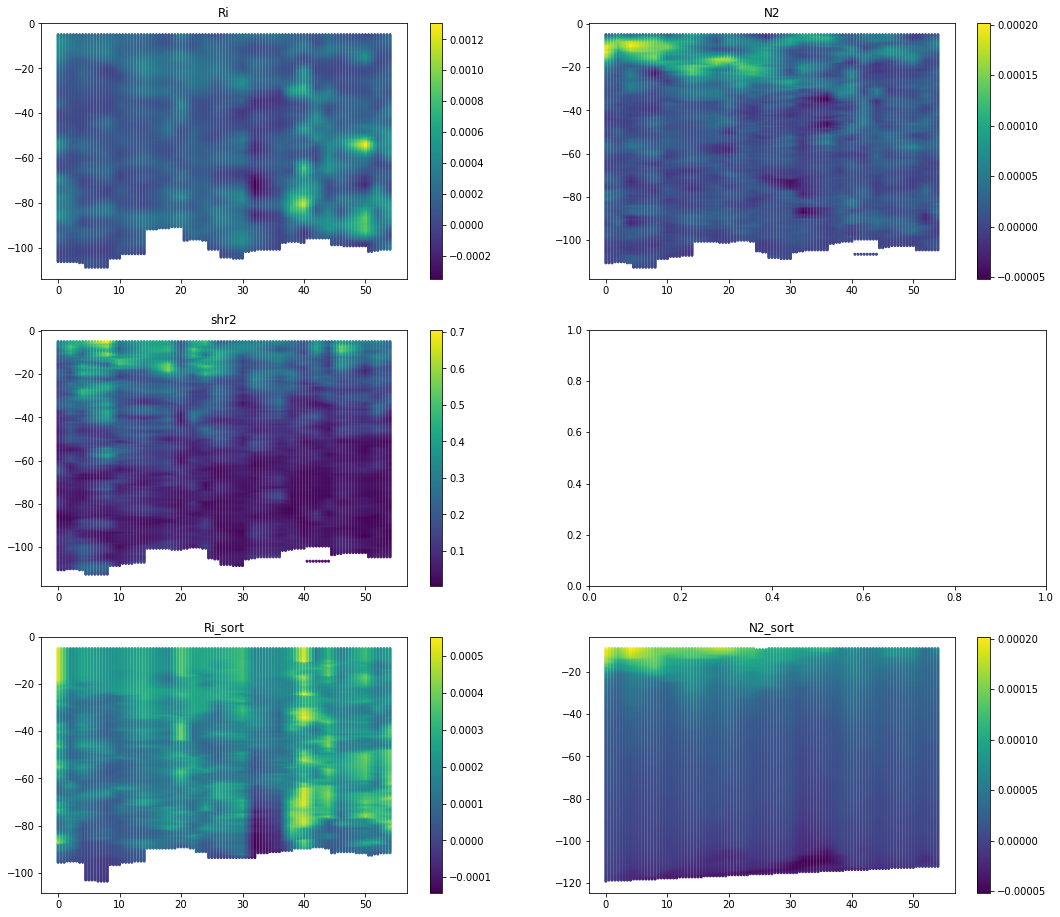

In [44]:
xi,yi = np.meshgrid(np.arange(0,56,0.5),np.arange(-120,0,0.5))
grid_N2 = griddata((grid['profile'],grid["z_ave"]),grid['N2'],(xi,yi),method='linear')
grid_S2 = griddata((grid['profile'],grid["z_ave"]),grid['shr2'],(xi,yi),method='linear')
grid_Ri = griddata((grid['profile'],grid["z_ave"]),grid['Ri'],(xi,yi),method='linear')
grid_N2_sort = griddata((grid['profile'],grid["z_ave"]),grid['N2_sort'],(xi,yi),method='linear')
grid_Ri_sort = griddata((grid['profile'],grid["z_ave"]),grid['Ri_sort'],(xi,yi),method='linear')

fig, axes = plt.subplots(3,2,figsize=(18, 16))

im1 = axes[0,0].scatter(xi,yi,s=4,c=grid_Ri)
axes[0,0].set_title('Ri')
im2 = axes[0,1].scatter(xi,yi,s=4,c=grid_N2)
axes[0,1].set_title('N2')
im3 = axes[1,0].scatter(xi,yi,s=4,c=grid_S2)
axes[1,0].set_title('shr2')
fig.colorbar(im1, ax = axes[0,0])
fig.colorbar(im2, ax = axes[0,1])
fig.colorbar(im3, ax = axes[1,0])


im4 = axes[2,0].scatter(xi,yi,s=4,c=grid_Ri_sort)
axes[2,0].set_title('Ri_sort')
im5 = axes[2,1].scatter(xi,yi,s=4,c=grid_N2_sort)
axes[2,1].set_title('N2_sort')
fig.colorbar(im4, ax = axes[2,0])
fig.colorbar(im5, ax = axes[2,1])